# **FNN**
- Using data that was not annotated
- Training it on the unbalanced data
- Using avgpool
- 6 second window

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
import pygame
import time
from scipy.signal import butter, filtfilt
import random

In [567]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/Annotated/AveragePooled/split_features_1s_all.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [568]:
train_data = data['train'].copy()
val_data = data['val'].copy()

In [569]:
train_data

{'melspectrogram': array([[9.4866091e-06, 9.5487494e-06, 9.6551566e-06, ..., 9.8847534e-07,
         9.3044491e-07, 9.0232516e-07],
        [1.2129851e-05, 1.2414495e-05, 1.2921279e-05, ..., 5.2223759e-06,
         4.9851474e-06, 4.8430848e-06],
        [5.8306232e-05, 5.9333925e-05, 6.1116712e-05, ..., 1.7024886e-06,
         1.6033545e-06, 1.5549887e-06],
        ...,
        [1.7914819e-04, 1.8226101e-04, 1.8773414e-04, ..., 2.3687387e-06,
         1.6498615e-06, 1.5470791e-06],
        [1.9102510e-05, 1.9464049e-05, 2.0094065e-05, ..., 4.9249811e-06,
         4.0005261e-06, 3.6747458e-06],
        [9.0032081e-06, 9.2558430e-06, 9.7203119e-06, ..., 9.5587347e-07,
         4.5187107e-07, 4.2664561e-07]], dtype=float32),
 'mfcc': array([[-1.        , -0.03889354, -0.64160925, ..., -0.02376524,
          0.02349628, -0.00874254],
        [-1.        , -0.0368154 , -0.633421  , ..., -0.02121266,
          0.0290794 , -0.01421679],
        [-1.        , -0.028492  , -0.6135318 , ..., -0.

In [570]:
train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

In [571]:
val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

# Shuffle Data

In [572]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [573]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [574]:
val_y, val_features = shuffle_data(val_labels, v_features)

In [575]:
display(train_y.shape)
display(train_y[:15])

(12565,)

array([ 0, 19,  2,  1, 11, 17, 15,  2,  2,  2,  0,  1,  1, 12,  0],
      dtype=int32)

In [576]:
for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'melspectrogram'

(12565, 60)

array([5.0738169e-07, 5.2262533e-07, 5.5045160e-07, 5.9217962e-07,
       6.5191085e-07, 1.0943645e-06, 4.3586356e-06, 1.9036837e-05,
       1.2136879e-04, 2.6661658e-04, 8.2672836e-04, 2.7233763e-03,
       1.0063773e-02, 1.6930899e-02, 2.1348633e-02, 4.7072649e-02,
       7.6561354e-02, 4.7709879e-02, 6.2269606e-02, 7.6247416e-02,
       6.1358120e-02, 3.9835755e-02, 4.4739708e-02, 5.0686374e-02,
       4.4587012e-02, 5.6312285e-02, 4.7983538e-02, 5.3998958e-02,
       9.1156095e-02, 1.2960179e-01, 1.3472772e-01, 7.4508280e-02,
       2.8677055e-01, 4.0667152e-01, 7.1514398e-01, 6.9495946e-01,
       3.1333745e-01, 2.0148984e-01, 1.1326054e-01, 6.4187691e-02,
       7.1493596e-02, 8.1204779e-02, 7.1447775e-02, 5.0326228e-02,
       3.6310278e-02, 2.3586553e-02, 1.3296669e-02, 4.2282213e-03,
       3.2108359e-03, 4.2909747e-03, 3.0864956e-02, 6.0674440e-02,
       5.0374899e-02, 3.0964591e-02, 4.0448662e-03, 3.0534746e-04,
       3.1673382e-05, 3.8426388e-06, 2.3940433e-06, 2.1029000e

'mfcc'

(12565, 20)

array([-1.        , -0.16236389, -0.4283241 ,  0.04256841, -0.05486935,
        0.01894294,  0.00423389,  0.10348184, -0.03871864,  0.0294642 ,
       -0.02652909,  0.01274641, -0.01874611, -0.00494358,  0.02157117,
       -0.01889195,  0.00154897, -0.01315036,  0.00566544, -0.00682729],
      dtype=float32)

'chroma'

(12565, 12)

array([0.18776874, 0.15328921, 0.33524922, 0.454852  , 0.7760426 ,
       0.67847323, 0.3407292 , 0.24142714, 0.18064852, 0.15764236,
       0.18976806, 0.2140399 ], dtype=float32)

'rms'

(12565, 1)

array([0.0295004], dtype=float32)

In [577]:
display(val_y.shape)
display(val_y[:15])

(3318,)

array([ 3,  2,  1,  0,  0,  8, 19,  2, 19,  5, 19, 15, 11,  7,  2],
      dtype=int32)

In [578]:
for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

'melspectrogram'

(3318, 60)

array([1.8282815e-04, 1.8516471e-04, 1.8923497e-04, 1.9535325e-04,
       2.0405794e-04, 2.1621672e-04, 2.3355127e-04, 2.6386356e-04,
       3.8294177e-04, 8.7105710e-04, 4.0952233e-03, 7.9782819e-03,
       1.2021556e-02, 1.1450265e-02, 1.8598879e-02, 4.5423362e-02,
       5.1051736e-02, 2.1339525e-02, 2.7392777e-02, 2.3795826e-02,
       1.3348093e-02, 1.3525566e-02, 8.1301248e-03, 8.5273301e-03,
       1.1604097e-02, 7.5979652e-03, 4.1982550e-03, 4.9553681e-03,
       6.7672539e-03, 8.9110127e-03, 1.0491555e-02, 8.9149661e-03,
       8.2060061e-03, 6.9327699e-03, 7.8629563e-03, 8.1582973e-03,
       7.1896906e-03, 3.3999698e-03, 3.0463785e-03, 5.0475681e-03,
       5.0008059e-03, 4.5382837e-03, 4.0109674e-03, 4.0369830e-03,
       9.5070582e-03, 1.8515797e-02, 5.2194532e-02, 2.4449244e-01,
       2.7477503e-01, 5.4956347e-01, 6.2898314e-01, 4.4136560e-01,
       5.3704370e-02, 2.4117595e-02, 1.1598948e-02, 4.3818848e-03,
       2.8213693e-04, 6.7681176e-06, 2.1489736e-06, 2.1393287e

'mfcc'

(3318, 20)

array([-1.0000000e+00, -1.0882675e-01, -1.4413263e-01, -6.7996904e-02,
       -1.5429229e-01,  7.5967886e-02, -1.1015258e-01,  1.3946199e-01,
       -3.3290099e-02,  4.8340354e-02,  2.1415181e-02, -1.9456839e-02,
        2.5275797e-02, -2.4598164e-02, -8.1183799e-03,  6.0081406e-04,
       -2.5172167e-02,  8.5308263e-03, -9.6246637e-03,  7.1927463e-04],
      dtype=float32)

'chroma'

(3318, 12)

array([0.02229075, 0.02539484, 0.03112359, 0.1376025 , 0.2878612 ,
       0.39549676, 0.5717799 , 0.5721824 , 0.20036055, 0.06311192,
       0.03563747, 0.02806006], dtype=float32)

'rms'

(3318, 1)

array([0.03920381], dtype=float32)

## **FNN Model**

In [592]:
def build_model(input_features,
                hidden_layers=[256, 128, 64],
                learning_rate=0.00005,
                output_units=20,
                dropout_rate=0.4):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(input_features,), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          name=f'hidden{i}')(hidden_output)
    # hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [580]:
def visualize(model_history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [581]:
train_results = {}
val_results = {}

### **With all the features**

In [590]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['rms'], train_features['melspectrogram']), axis=1)
training_features.shape

(12565, 93)

In [589]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['rms'], val_features['melspectrogram']), axis=1)

validation_features.shape

(3318, 93)

Fit the model with training data

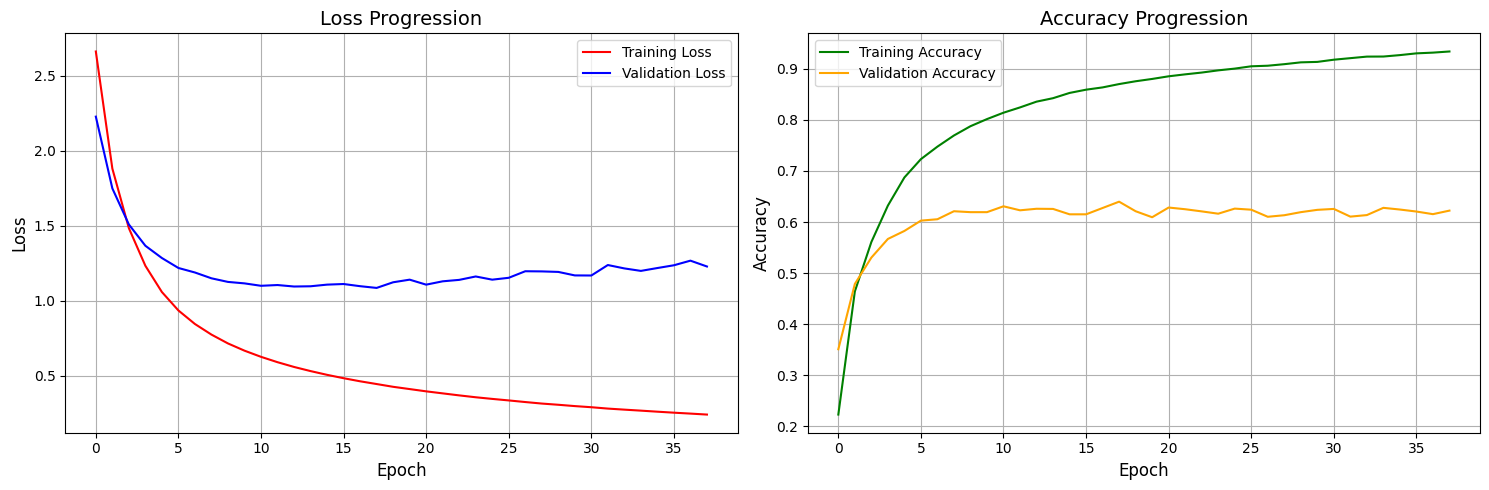

In [593]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/1s_all_features_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=64,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [594]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8764 - loss: 0.4226
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6466 - loss: 1.0875


# Review results from all models

In [ ]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df